# Script 3 - Training a convolutional neural network on image data
### Final Project in Data Mining, Machine Learning, and Deep Learning

Erik Konstenius, Theodore Balas and Muhammad Azkaenza

This script creates a VGG16 model and a VGG19 model to create price estimates of paintings given a dataset of images of paintings. Script 3 requires that you first run script 1.

In [1]:
#!pip install fast-ml pandas numpy matplotlib keras tensorflow more_itertools tqdm sklearn seaborn openpyxl pydot

In [3]:
import numpy as np
from numpy import asarray
import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import csv
from more_itertools import chunked
import fnmatch
import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm, tqdm_notebook
from keras.utils.vis_utils import plot_model # need to install graphviz

# Load data

In [20]:
# folder name for split train, validation, and test
folder = 'extracted_files/split_folder'
subfolder = ['train', 'valid', 'test']

# directory for train, validation, and test dataset (images & csv files)
train_f = folder+'/'+subfolder[0]
valid_f = folder+'/'+subfolder[1]
test_f = folder+'/'+subfolder[2]

In [4]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_valid = pd.read_csv('X_valid.csv', index_col=0)
y_valid = pd.read_csv('y_valid.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [5]:
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [6]:
train_images = np.load('train_images.npy')
valid_images = np.load('valid_images.npy') 
test_images = np.load('test_images.npy')

In [21]:
print(str(y_train.shape) + "---" + str(y_train.dtype))
print(str(y_valid.shape) + "---" + str(y_valid.dtype))
print(str(y_test.shape) + "---" + str(y_test.dtype))
print(str(train_images.shape) + "---" + str(train_images.dtype))
print(str(valid_images.shape) + "---" + str(valid_images.dtype))
print(str(test_images.shape) + "---" + str(test_images.dtype))

(48000, 1)---float64
(6000, 1)---float64
(6000, 1)---float64
(48000, 224, 224, 3)---float32
(6000, 224, 224, 3)---float32
(6000, 224, 224, 3)---float32


In [22]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# VGG16

In [4]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('71100/results', monitor="val_loss", verbose=0, save_best_only=False, save_freq ='epoch')
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# we will not update the weights of the first 5 layers of the CNN as the images share some weak similarities.
for layer in model_VGG16.layers[:6]:
    layer.trainable = False

x = model_VGG16.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation="linear")(x) # linear activation function for regression task

model_VGG16 = keras.Model(inputs=model_VGG16.input, outputs=x)

58900480/58889256 [==============================] - 69s 1us/step


In [6]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov=True)

# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_VGG16.compile(loss='mean_squared_error', optimizer= opt, metrics=[mse, r_square])

In [7]:
model_VGG16.summary(expand_nested=True, show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [ ]:
plot_model(model_VGG19, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

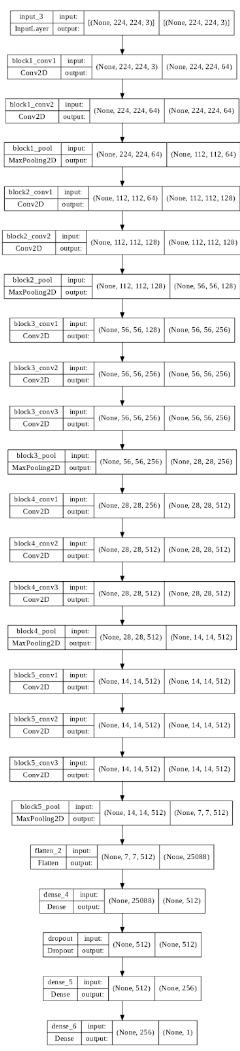

In [ ]:
VGG16 = model_VGG16.fit(train_images, y_train, epochs=10, validation_data=(valid_images, y_valid), use_multiprocessing = True, verbose = 1, callbacks=[early_stop, checkpoint])

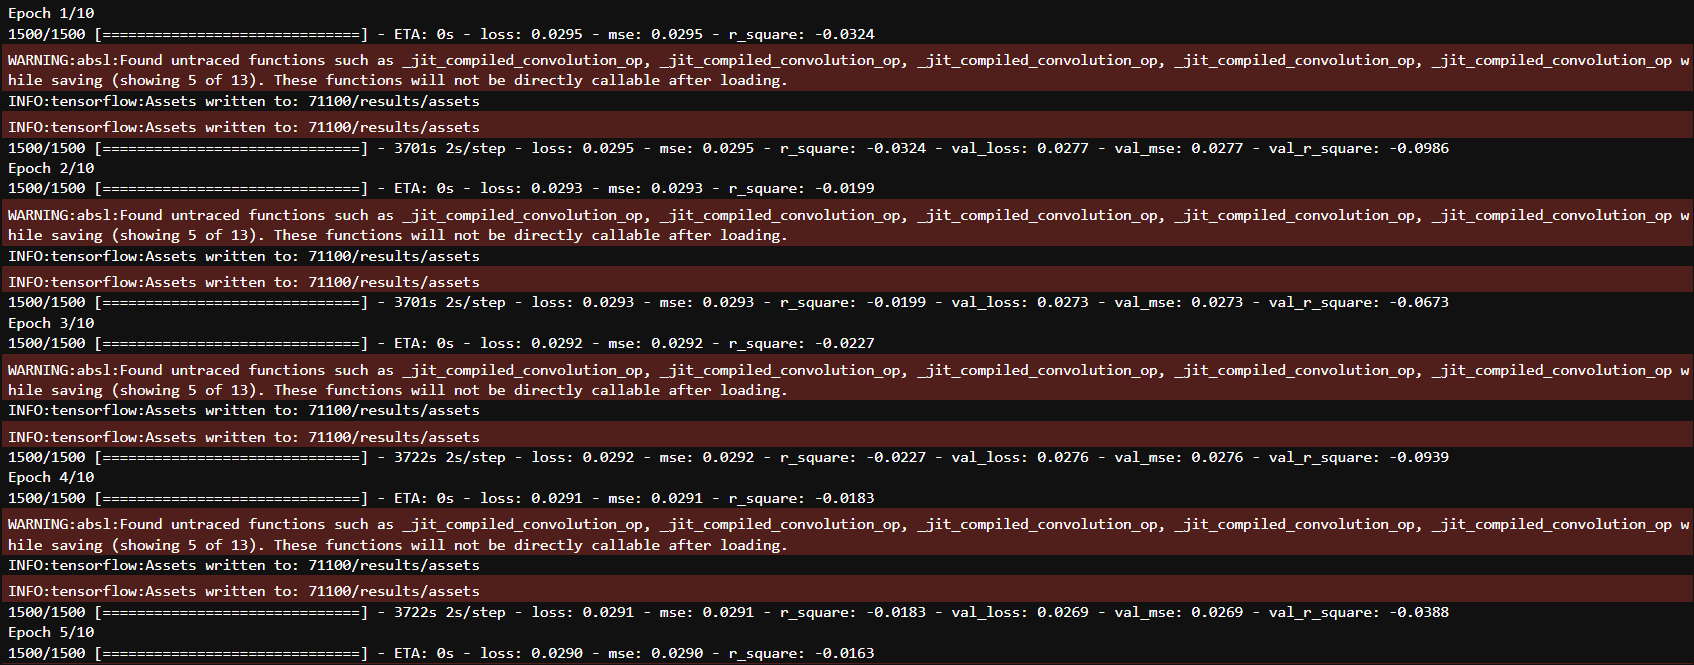

In [8]:
y_pred_test_VGG16 = model_VGG16.predict(test_images) 

In [9]:
plt.plot(VGG16.history['loss'], label='MSE (training)')
plt.plot(VGG16.history['val_loss'], label='MSE (validation)')
plt.title('MSE for art price predictions')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

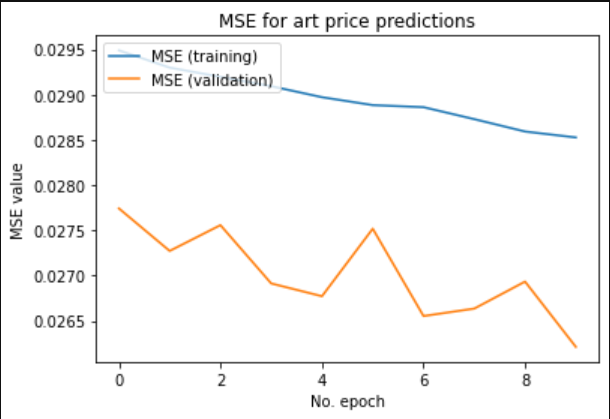

In [10]:
plt.plot(VGG16.history['r_square'], label='r_square (training)')
plt.plot(VGG16.history['val_r_square'], label='val_r_square (validation)')
plt.title('Model r_square')
plt.ylabel('r_square')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

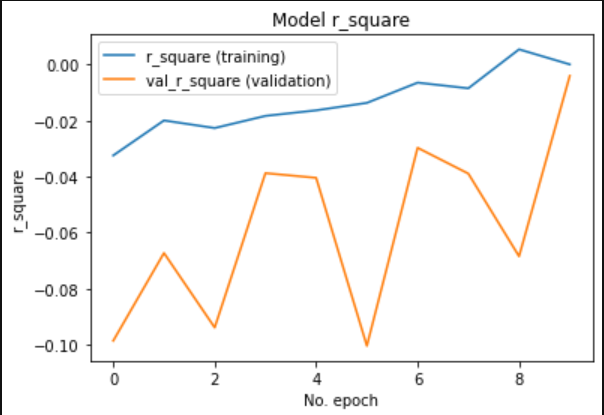

In [11]:
print('R2  : ', r2_score(y_test, y_pred_test_VGG16))
print('MAE : ', mean_absolute_error(y_test, y_pred_test_VGG16))
print('MSE : ', mean_squared_error(y_test, y_pred_test_VGG16))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test_VGG16)))

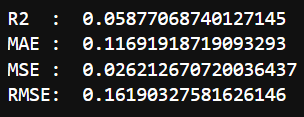

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_test_VGG16, c='crimson')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

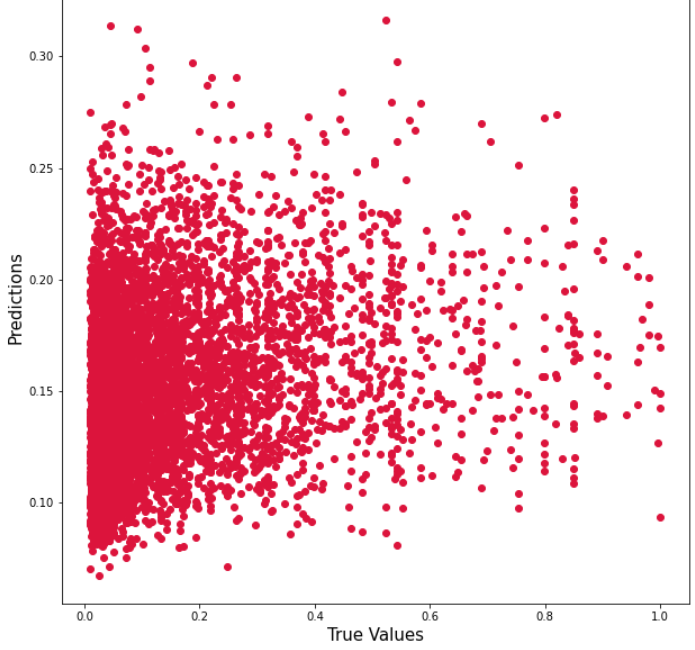

# VGG19

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('71100/results', monitor="val_loss", verbose=0, save_best_only=False, save_freq ='epoch')
# This callback will stop the training when there is no improvement in
# the loss for five consecutive epochs.

model_VGG19_2 = VGG19(include_top=False, input_shape=(224, 224, 3))

# we will not update the weights of the first eight layers of the CNN as the images share 
# some weak similarities.
for layer in model_VGG19_2.layers[:8]:
    layer.trainable = False

x = model_VGG19_2.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x) # used to standardize and reguralize 
x = Dense(64, activation='relu')(x)
x = Dense(1, activation="linear")(x) # linear activation function for regression task

model_VGG19_2 = keras.Model(inputs=model_VGG19_2.input, outputs=x)

In [24]:
opt = tf.keras.optimizers.SGD(learning_rate=0.05, nesterov=False)
model_VGG19_2.compile(loss='mean_squared_error', optimizer= opt, metrics=[mse, r_square])

In [ ]:
# our early stopping was previously too sensitive which cause our training to stop after 3 epochs. We saved the weights and continue the last 7 epochs by load those weights.
model_VGG19_2.load_weights('VGG19.h5')

In [25]:
model_VGG19.summary(expand_nested=True, show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1475

In [ ]:
plot_model(model_VGG19_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

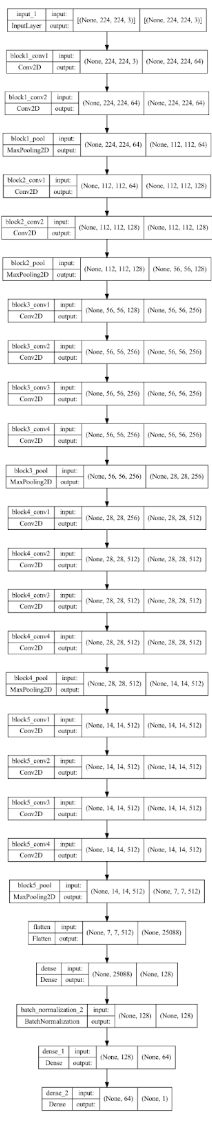

In [3]:
# Note, we only train for 7 epochs due to a previous too sensitive early stopping that stopped 
# training after 3 epochs.

VGG19 = model_VGG19.fit(train_images, y_train, epochs=10, validation_data=(valid_images,y_valid), use_multiprocessing = True, verbose = 1, callbacks=[early_stop])

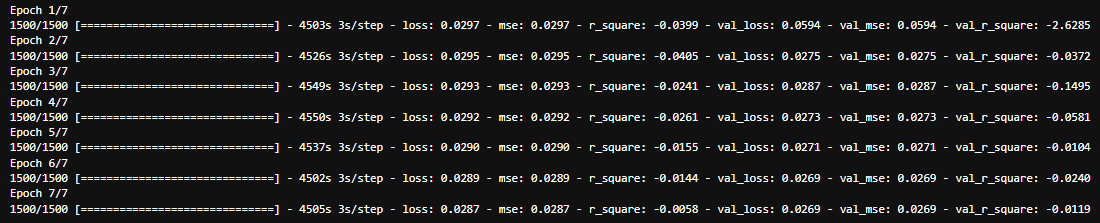

In [4]:
#model_VGG19.save('VGG19_1.h5')

In [ ]:
plt.plot(VGG19_2.history['loss'], label='MSE (training)')
plt.plot(VGG19_2.history['val_loss'], label='MSE (validation)')
plt.title('VGG19 MSE')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

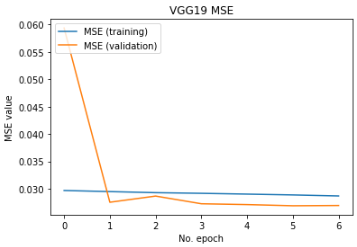

In [ ]:
plt.plot(VGG19_1.history['r_square'], label='r_square (training data)')
plt.plot(VGG19_.history['val_r_square'], label='val_r_square (validation data)')
plt.title('Model r_square')
plt.ylabel('r_square')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

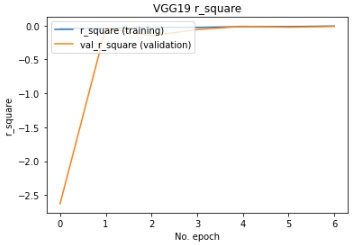

In [ ]:
y_pred_train_VGG19_2 = model_VGG19.predict(train_images) 
np.save('y_pred_train_VGG19_1.npy', y_pred_train_VGG19_1)

In [ ]:
y_pred_test_VGG19_1 = model_VGG19.predict(test_images) 
np.save('y_pred_test_VGG19_1.npy', y_pred_test_VGG19_1)

In [ ]:
print("R2: " + str(r2_score(y_test, y_pred_test_VGG19_2)))
print("MSE: " + str(mean_squared_error(y_test, y_pred_test_VGG19_2)))

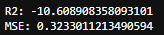

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_test_VGG19_2, c='crimson')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

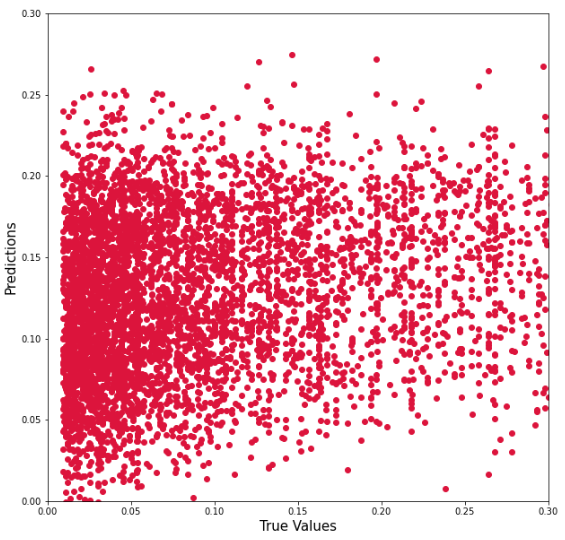